# CRM ANALYTICS


# RFM Analysis
## Veriyi Anlama

### İş Problemi
Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
pazarlama stratejileri belirlemek istiyor.
Örneğin şirket için çok kazançlı olan müşterileri elde tutmakiçin farklı kampanyalar, yeni müşteriler için farklı kampanyalar düzenlenmek istenmektedir.


### Veri Seti Hikayesi
* Veri seti  01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.
* Bu projede 2010-2011 yılları arası incelenecektir.
* Bu şirketin ürün kataloğunda hediyelik eşyalar yer almaktadır.
* Şirketin müşterilerinin büyük çoğunluğu kurumsal müşterilerdir.


### Değişkenler
* InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
* StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
* Description: Ürün ismi
* Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
* InvoiceDate: Fatura tarihi ve zamanı.
* UnitPrice: Ürün fiyatı (Sterlin cinsinden)
* CustomerID: Eşsiz müşteri numarası
* Country: Müşterinin yaşadığı ülke.


### Kütüphaneler

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # Uyarılar
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-retail-ii-uci-two-peroid/online_retail_II_2009_2010.csv
/kaggle/input/online-retail-ii-uci-two-peroid/online_retail_II_2010_2011.csv


In [2]:
online_retail = pd.read_csv("../input/online-retail-ii-uci-two-peroid/online_retail_II_2010_2011.csv", sep=";")
df = online_retail.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1.12.2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1.12.2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1.12.2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1.12.2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1.12.2010 08:26,3.39,17850.0,United Kingdom


### Veri Önişleme

In [3]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(df)

################ Shape ####################
(541910, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
############### Types #####################
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object
############### Head ######################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

       InvoiceDate  Price  Customer ID         Country 

In [4]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [6]:
# Analizimizde satın almalarla ilgileniyoruz.Bu nedenle iade işlemleri veriden çıkardık.

df = df[~df["Invoice"].str.contains("C", na=False)]
df.shape

(397925, 8)

In [7]:
# Aykırı Gözlemler

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

### Keşifçi Veri Analizi

##### Kategorik Değişken Analizi

In [8]:
cat_cols = [col for col in df.columns if df[col].dtypes =="O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > 100 and df[col].dtypes == "O"]
cat_cols = [col for col in cat_cols if col not in cat_but_car]
cat_cols


['Country']

                      Country      Ratio
United Kingdom         354345  89.048187
Germany                  9042   2.272287
France                   8343   2.096626
EIRE                     7238   1.818936
Spain                    2485   0.624490
Netherlands              2363   0.593830
Belgium                  2031   0.510398
Switzerland              1842   0.462901
Portugal                 1462   0.367406
Australia                1185   0.297795
Norway                   1072   0.269397
Italy                     758   0.190488
Channel Islands           748   0.187975
Finland                   685   0.172143
Cyprus                    614   0.154300
Sweden                    451   0.113338
Austria                   398   0.100019
Denmark                   380   0.095495
Poland                    330   0.082930
Japan                     321   0.080668
Israel                    248   0.062323
Unspecified               244   0.061318
Singapore                 222   0.055789
Iceland         

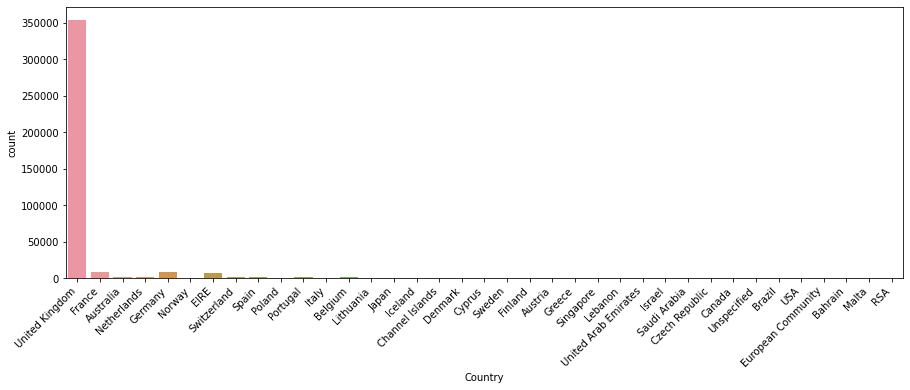

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        fig_dims = (15, 5)
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation = 45, ha = 'right')
        plt.show()

cat_summary(df, "Country", plot=True)

#### Nümerik Değişken Analizi

In [10]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Customer ID"]
num_cols

['Quantity', 'Price']

count    397925.000000
mean         11.833709
std          25.534486
min           1.000000
5%            1.000000
10%           1.000000
20%           2.000000
30%           2.000000
40%           4.000000
50%           6.000000
60%           8.000000
70%          12.000000
80%          12.000000
90%          24.000000
95%          36.000000
99%         120.000000
max         298.500000
Name: Quantity, dtype: float64


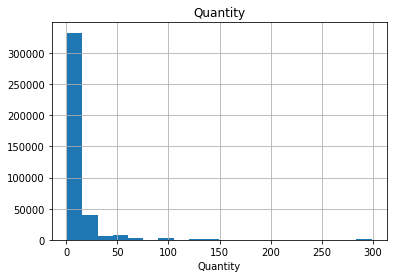

count    397925.000000
mean          2.893201
std           3.227143
min           0.000000
5%            0.420000
10%           0.550000
20%           0.850000
30%           1.250000
40%           1.650000
50%           1.950000
60%           2.100000
70%           2.950000
80%           4.150000
90%           6.350000
95%           8.500000
99%          14.950000
max          37.060000
Name: Price, dtype: float64


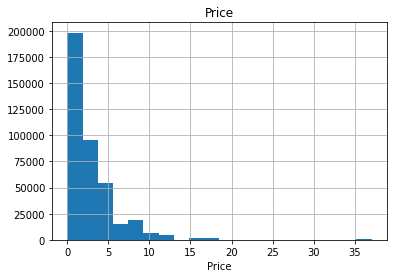

In [11]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [12]:
# eşsiz ürün sayısı
df["StockCode"].nunique()

3665

In [13]:
# hangi üründen kaçar adet alınmış ?
df_product = df.groupby("StockCode").agg({"Quantity":"count"})
df_product.reset_index(inplace=True)
df_product

,StockCode,Quantity
0,10002,49
1,10080,21
2,10120,30
3,10123C,3
4,10124A,5
...,...,...
3660,C2,133
3661,DOT,16
3662,M,290
3663,PADS,4


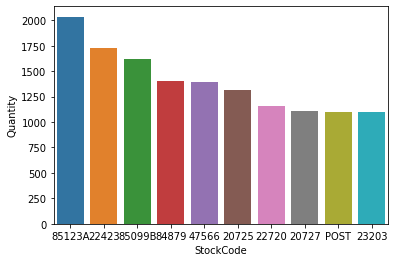

In [14]:
# en çok alınan 10 ürün
top_pr= df_product.sort_values(by="Quantity",ascending=False).head(10)

sns.barplot(x="StockCode", y="Quantity",data=top_pr)
plt.show()

In [15]:
# fatura basına düsen toplam fiyatı veri setin ekleme
df["TotalPrice"] = df["Price"] * df["Quantity"]

### RFM Metriklerinin Hazırlanması

* recency: bugün ile müşterinin en son satın alma tarihi arasındaki fark, gün cinsinden
* frequency: müşterinin alışveriş sıklığı
* monetary: müşterinin ödediği toplam para


In [16]:
# recency hesabı için analiz tarihinin belirlenmesi
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [17]:
# rfm metriklerini oluşturma
rfm = df.groupby("Customer ID").agg({"InvoiceDate": lambda InvıiceDate: (today_date- InvıiceDate.max()).days,
                                    "Invoice": lambda Invoice: Invoice.nunique(),
                                    "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["recency","frequency","monetary"]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4339.0,105.461858,115.083263,0.0,22.000,61.00,161.500,697.000
frequency,4339.0,4.271952,7.705493,1.0,1.000,2.00,5.000,210.000
monetary,4339.0,1891.748117,7705.372078,0.0,303.125,662.59,1630.445,266163.525


In [18]:
# monetary yani ödenen toplam paranın min değeri 0 işlem yapılmış para girişi olmamış
# bunları veriden çıkaröalıyım

rfm = rfm[rfm["monetary"] > 0]
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,105.482711,115.088330,0.00,22.0000,61.0,161.7500,697.000
frequency,4338.0,4.272706,7.706221,1.00,1.0000,2.0,5.0000,210.000
monetary,4338.0,1892.184204,7706.206805,3.75,303.3075,663.1,1631.1075,266163.525


#### RFM Skorlarının Oluşturulması

In [19]:
# recency_score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
# frequency_score
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# monetary_score
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

# hepsinden oluşan RFM Scoru
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm.head(10)

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.0,326,1,310.44,1,1,2,11
12347.0,40,7,4310.00,4,5,5,45
12348.0,76,4,1770.78,3,4,4,34
12349.0,19,1,1491.72,4,1,4,41
12350.0,311,1,331.46,1,1,2,11
12352.0,73,8,1756.34,3,5,4,35
12353.0,205,1,89.00,1,1,1,11
12354.0,233,1,1079.40,1,1,4,11
12355.0,96,1,459.40,2,1,2,21


#### RFM Skorlarına Göre Müşterilerin Segmentlere Ayrılması

In [20]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head(10)


,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
12346.0,326,1,310.44,1,1,2,11,hibernating
12347.0,40,7,4310.00,4,5,5,45,loyal_customers
12348.0,76,4,1770.78,3,4,4,34,loyal_customers
12349.0,19,1,1491.72,4,1,4,41,promising
12350.0,311,1,331.46,1,1,2,11,hibernating
12352.0,73,8,1756.34,3,5,4,35,loyal_customers
12353.0,205,1,89.00,1,1,1,11,hibernating
12354.0,233,1,1079.40,1,1,4,11,hibernating
12355.0,96,1,459.40,2,1,2,21,hibernating


In [21]:
# Segmentlere göre RFM ortalama ve sıklık değerlerini gruplayalım
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])


recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        64.073746   339   1.147493   339   493.585888   339
at_Risk              171.670068   588   2.829932   588   883.240104   588
cant_loose           134.205882    68   8.235294    68  3212.518235    68
champions              9.300752   665  11.717293   665  5969.704098   665
hibernating          244.009355  1069   1.099158  1069   376.698107  1069
loyal_customers       42.165184   787   6.819568   787  2994.232662   787
need_attention        63.877551   196   2.387755   196   886.904291   196
new_customers         11.153846    52   1.000000    52   337.768846    52
potential_loyalists   20.343096   478   2.033473   478   736.627939   478
promising             28.708333    96   1.000000    96   319.406875    96

#### Segmentlerin Görselleştirilmesi

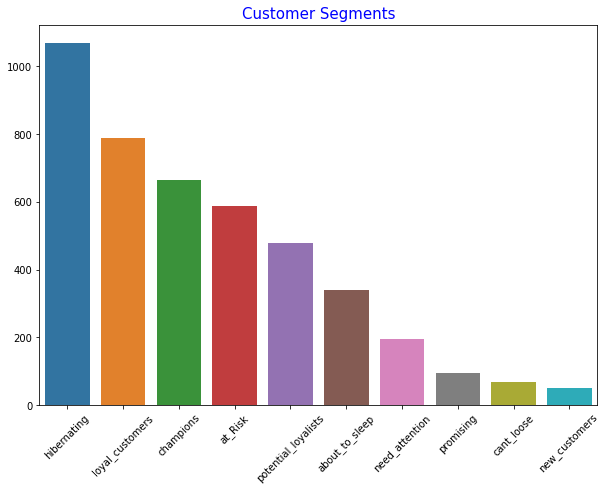

In [22]:
sgm= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

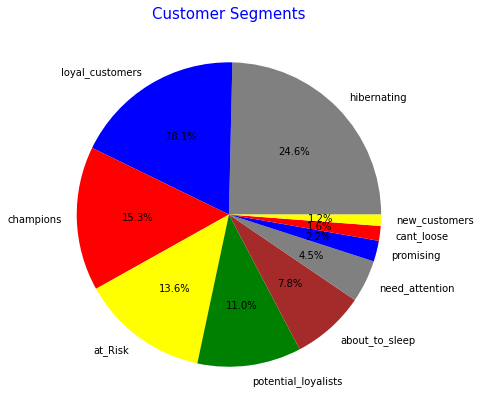

In [23]:
labels = rfm["segment"].value_counts().index
colors = ['grey','blue','red','yellow','green','brown']
sizes = rfm["segment"].value_counts().values

# visual
plt.figure(figsize = (7,7))
plt.pie(sizes, explode=None, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Customer Segments',color = 'blue',fontsize = 15)
plt.show()

# CLTV Prediction

### İş Problemi
Bir e-ticaret şirketi satış ve pazarlama faaliyetleri için roadmap belirlemek istemektedir.Şirketin orta uzun vadeli plan yapabilmesi için var olan müşterilerin gelecekte şirkete sağlayacakları potansiyel değerin tahmin edilmesi gerekmektedir.

### Kütüphaneler

In [24]:
!pip install Lifetimes

     |████████████████████████████████| 584 kB 1.3 MB/s 


In [25]:
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/online-retail-ii-uci-two-peroid/online_retail_II_2009_2010.csv
/kaggle/input/online-retail-ii-uci-two-peroid/online_retail_II_2010_2011.csv


### Life Time Veri Yapısının Hazırlanması
* recency: müşterinin kendi özelinde son alısverisi ile ilk alısverisi arasındaki fark
* T: müşterinin şirketteki yaşı
* frequency: tekrar eden toplam satın alma sayısı
* monetary_value: satın alma başına ortalama kazanç


In [26]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,326,1,310.44
12347.0,475,516,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [27]:
# monetary değerini toplam totalPrice olarak hesaplamıştık.
# bu aşamada moneary değerini satın alma başına ortalama kazanç olarak ifade edeceğiz
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# monetary nin sıfırdan büyük olanlarının seçelimesi
cltv_df = cltv_df[cltv_df["monetary"] > 0]

# BGNBD için recency ve T'nin haftalık cinsten ifade edilmesi
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

# frequency nin 1 den büyük olanlarının seçilmesi
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0,67.857143,73.714286,7,615.714286
12348.0,40.285714,51.285714,4,442.695000
12352.0,38.285714,48.714286,8,219.542500
12356.0,43.142857,46.571429,3,937.143333
12358.0,16.571429,17.142857,2,575.210000


### BG-NBD Modelinin Kurulması
* Bu modelle amacım satın alma sayısını olasılıksal olarak tahmin etmek

In [28]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.11, alpha: 16.47, b: 2.40, r: 2.54>

In [29]:
# 1 haftalık beklenen satın alma (transection)
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_week", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12748.0,98.857143,99.571429,210,154.192429,1.827347
14911.0,99.571429,99.571429,201,691.710100,1.752303
14646.0,50.428571,50.714286,74,3596.804392,1.136107
17841.0,99.428571,99.571429,124,330.134355,1.088879
13089.0,81.571429,82.428571,97,606.362474,1.003352
14606.0,98.714286,99.571429,93,130.139032,0.821054
15311.0,99.571429,99.571429,91,667.779121,0.804774
12971.0,93.714286,95.142857,86,127.485872,0.789880
18102.0,71.857143,73.714286,60,3859.739083,0.688662


In [30]:
# 1 aylık beklenen satın alma
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12748.0,98.857143,99.571429,210,154.192429,1.827347,7.299497
14911.0,99.571429,99.571429,201,691.710100,1.752303,6.999726
14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835
17841.0,99.428571,99.571429,124,330.134355,1.088879,4.349602
13089.0,81.571429,82.428571,97,606.362474,1.003352,4.007018
14606.0,98.714286,99.571429,93,130.139032,0.821054,3.279748
15311.0,99.571429,99.571429,91,667.779121,0.804774,3.214712
12971.0,93.714286,95.142857,86,127.485872,0.789880,3.155050
18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817


### GAMMA-GAMMA Modelinin Kurulması
* Bu modelle amaç average ptofiti yani işlem başına ortalama karı olasılıksal olarak modellemek

In [31]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [32]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0,44.857143,48.571429,21,5724.302619,0.354868,1.415956,5772.177190
12590.0,0.000000,0.714286,2,4591.172500,0.253409,1.003368,5029.409866
12435.0,26.857143,38.285714,2,3914.945000,0.075898,0.302550,4288.935706
12409.0,2.000000,11.428571,3,3690.890000,0.160184,0.636701,3918.807905
14088.0,44.571429,46.142857,13,3864.554615,0.245228,0.978338,3917.128640
18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817,3870.996702
12753.0,48.428571,51.857143,6,3571.565000,0.122104,0.487178,3678.576111
14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835,3605.309159
15749.0,28.000000,33.714286,3,3028.780000,0.105223,0.419373,3216.048315


* İncelendiğinde kar getirisi en yüksek olan kişiden daha fazla alısveris yapan biri daha az kar getirmiş.Burada terslik var demek ki sadece buraya göre bir cltv pred. yapamam bu iki modeli çarpıstırmam gerek.


### BG-NBD ve GG modeli ile CLTV'nin çarpıştırılması


In [33]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [34]:
# ID indexte bunu indexten çıkaralım
cltv = cltv.reset_index()
# ana tablom ile tahmin değerleri tablosunu birleştiriyorum
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# azalan şekilde sıralayalım
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835,3605.309159,101354.260976
2761,18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817,3870.996702,66231.454404
36,12415.0,44.857143,48.571429,21,5724.302619,0.354868,1.415956,5772.177190,50635.571468
2458,17450.0,73.142857,73.714286,46,2863.274891,0.536241,2.141185,2874.198462,38290.155237
1257,14911.0,99.571429,99.571429,201,691.710100,1.752303,6.999726,692.326355,30228.429482
128,12590.0,0.000000,0.714286,2,4591.172500,0.253409,1.003368,5029.409866,30192.793641
874,14156.0,91.000000,91.142857,55,2104.026727,0.533315,2.130109,2110.754090,28023.727545
843,14096.0,41.714286,43.428571,17,3163.588235,0.322578,1.286822,3196.435385,25449.604996
2075,16684.0,49.428571,51.285714,28,2209.969107,0.446565,1.782048,2223.884691,24569.624580
841,14088.0,44.571429,46.142857,13,3864.554615,0.245228,0.978338,3917.128640,23722.085871


In [35]:
# 1 aylık CLTV hesaplayalım:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi
                                   discount_rate=0.01)

cltv_1.head()
cltv_1= cltv_1.reset_index()
cltv_1 = cltv_df.merge(cltv_1, on="Customer ID", how="left")
cltv_1.sort_values(by="clv", ascending=False).head(10)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835,3605.309159,17575.269295
2761,18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817,3870.996702,11445.861238
36,12415.0,44.857143,48.571429,21,5724.302619,0.354868,1.415956,5772.177190,8787.718717
2458,17450.0,73.142857,73.714286,46,2863.274891,0.536241,2.141185,2874.198462,6617.477987
128,12590.0,0.000000,0.714286,2,4591.172500,0.253409,1.003368,5029.409866,5421.386939
1257,14911.0,99.571429,99.571429,201,691.710100,1.752303,6.999726,692.326355,5211.147074
874,14156.0,91.000000,91.142857,55,2104.026727,0.533315,2.130109,2110.754090,4834.760264
843,14096.0,41.714286,43.428571,17,3163.588235,0.322578,1.286822,3196.435385,4422.421915
2075,16684.0,49.428571,51.285714,28,2209.969107,0.446565,1.782048,2223.884691,4261.122830
841,14088.0,44.571429,46.142857,13,3864.554615,0.245228,0.978338,3917.128640,4120.369850


In [36]:
# 12 aylık CLTV hesaplayalım:

cltv_12 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi
                                   discount_rate=0.01)

cltv_12.head()
cltv_12 = cltv_12.reset_index()
cltv_12 = cltv_df.merge(cltv_12, on="Customer ID", how="left")
cltv_12.sort_values(by="clv", ascending=False).head(10)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835,3605.309159,193981.621645
2761,18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817,3870.996702,127128.070870
36,12415.0,44.857143,48.571429,21,5724.302619,0.354868,1.415956,5772.177190,96845.409545
2458,17450.0,73.142857,73.714286,46,2863.274891,0.536241,2.141185,2874.198462,73492.915683
1257,14911.0,99.571429,99.571429,201,691.710100,1.752303,6.999726,692.326355,58151.659919
128,12590.0,0.000000,0.714286,2,4591.172500,0.253409,1.003368,5029.409866,56547.369323
874,14156.0,91.000000,91.142857,55,2104.026727,0.533315,2.130109,2110.754090,53872.293048
843,14096.0,41.714286,43.428571,17,3163.588235,0.322578,1.286822,3196.435385,48624.755886
2075,16684.0,49.428571,51.285714,28,2209.969107,0.446565,1.782048,2223.884691,47017.834619
841,14088.0,44.571429,46.142857,13,3864.554615,0.245228,0.978338,3917.128640,45340.185877


* 1 aylık ve 12 aylık tahminlere bakıldığında aynı müşterilerin iki durumda da clv tahminlerinin yüksek olduğunu görüyorum.
* Sadece bazı müşteriler yer değiştirmiş,ama çok fazla fark yok.
* Yani müşteriler 12 ay içinde alısveris alıskalnlıklarını aynı şekilde devam ettirmiş.


#### CLTV Tahminlerine Göre Müşterilerin Segmentlere Ayrılması

In [37]:
# clv tahminlerinin 0-1 aralığına normalize edilmesi
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

cltv_final.sort_values(by="scaled_clv", ascending=False).head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv
1122,14646.0,50.428571,50.714286,74,3596.804392,1.136107,4.533835,3605.309159,101354.260976,1.000000
2761,18102.0,71.857143,73.714286,60,3859.739083,0.688662,2.749817,3870.996702,66231.454404,0.653465
36,12415.0,44.857143,48.571429,21,5724.302619,0.354868,1.415956,5772.177190,50635.571468,0.499590
2458,17450.0,73.142857,73.714286,46,2863.274891,0.536241,2.141185,2874.198462,38290.155237,0.377785
1257,14911.0,99.571429,99.571429,201,691.710100,1.752303,6.999726,692.326355,30228.429482,0.298245


In [38]:
# Müşterilerin Segmentlere Ayrılması
cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head()

cltv_final.head()


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,scaled_clv,segment
0,12347.0,67.857143,73.714286,7,615.714286,0.103198,0.412005,631.911974,1618.376764,0.015968,A
1,12348.0,40.285714,51.285714,4,442.695000,0.090710,0.361884,463.745539,1038.738992,0.010249,B
2,12352.0,38.285714,48.714286,8,219.542500,0.150828,0.601746,224.886669,837.795788,0.008266,C
3,12356.0,43.142857,46.571429,3,937.143333,0.084935,0.338754,995.997679,2085.240043,0.020574,A
4,12358.0,16.571429,17.142857,2,575.210000,0.130291,0.518317,631.900951,1997.660314,0.019710,A


In [39]:
# segnmentlerin incelenmesi
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                           recency                \
              count         sum          mean   count           sum   
segment                                                               
D               712  11086991.0  15571.616573     712  20861.714286   
C               711  10938325.0  15384.423347     711  24703.142857   
B               711  10840482.0  15246.810127     711  25157.428571   
A               711  10640413.0  14965.419128     711  27178.285714   

                       T                          frequency  ...  \
              mean count           sum       mean     count  ...   
segment                                                      ...   
D        29.300161   712  34774.428571  48.840490       712  ...   
C        34.744223   711  30927.285714  43.498292       711  ...   
B        35.383163   711  29671.857143  41.732570       711  ...   
A        38.225437   711  30313.571429  42.635122       711  ...   

        expected_purc_1_month expected_average_profit                 \
                         mean                   count            sum   
segment                                                                
D                    0.260522                     712  137966.939940   
C                    0.424787                     711  202663.028994   
B                    0.540355                     711  271792.699654   
A                    0.821476                     711  503392.510172   

                      clv                            scaled_clv             \
               mean count           sum         mean      count        sum   
segment                                                                      
D        193.773792   712  1.850094e+05   259.844632        712   1.825373   
C        285.039422   711  4.605026e+05   647.682994        711   4.543495   
B        382.268213   711  7.991769e+05  1124.018193        711   7.884986   
A        708.006343   711  2.465660e+06  3467.876853        711  24.327151   

                   
             mean  
segment            
D        0.002564  
C        0.006390  
B        0.011090  
A        0.034215  

[4 rows x 30 columns]